# Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import sys
import random
import torch

from sklearn.impute import SimpleImputer  #결측치 자동
from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  #scaling
from imblearn.over_sampling import SMOTE #smote
from sklearn.utils.class_weight import compute_class_weight #scaling- weight


#DL Model
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
#from tensorflow.keras.optimizers import Adam
#from scikeras.wrappers import KerasClassifier

file_path = "../data/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df_original = pd.read_csv(file_path)  # 원본 데이터 저장
df = df_original.copy()  # 작업용 복사본 생성


## random seed


In [2]:
# 랜덤 시드 설정 (데이터셋 준비 전에 실행)
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # ⬅ 데이터셋 준비 전에 실행

# Preprocessing




In [4]:
import numpy as np
import pandas as pd

#from utils import reset_seeds
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm


In [5]:
def __create_custom_features(df):
    df = df.copy()  # 원본 데이터프레임 수정 방지

    #  숫자로 변환 (오류 방지)
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')
    df["tenure"] = pd.to_numeric(df["tenure"], errors='coerce')
    df["MonthlyCharges"] = pd.to_numeric(df["MonthlyCharges"], errors='coerce')

    #  NaN 값 처리
    df["TotalCharges"] = df["TotalCharges"].fillna(0)

    # 신규 피처 생성
    df.loc[(df["tenure"] >= 0) & (df["tenure"] <= 12), "NEW_TENURE_YEAR"] = "0-1 Year"
    df.loc[(df["tenure"] > 12) & (df["tenure"] <= 24), "NEW_TENURE_YEAR"] = "1-2 Year"
    df.loc[(df["tenure"] > 24) & (df["tenure"] <= 36), "NEW_TENURE_YEAR"] = "2-3 Year"
    df.loc[(df["tenure"] > 36) & (df["tenure"] <= 48), "NEW_TENURE_YEAR"] = "3-4 Year"
    df.loc[(df["tenure"] > 48) & (df["tenure"] <= 60), "NEW_TENURE_YEAR"] = "4-5 Year"
    df.loc[(df["tenure"] > 60) & (df["tenure"] <= 72), "NEW_TENURE_YEAR"] = "5-6 Year"

    #  Zero-Division 방지: tenure=0인 경우 1로 설정
    df["tenure_fixed"] = df["tenure"].replace(0, 1)

    #  연산 수행 가능하도록 수정 (무한대 발생 방지)
    df["NEW_AVG_Charges"] = df["TotalCharges"] / df["tenure_fixed"]

    # MonthlyCharges가 0이면 1로 보정하여 Zero-Division 방지
    df["MonthlyCharges_fixed"] = df["MonthlyCharges"].replace(0, 1)
    df["NEW_Increase"] = df["NEW_AVG_Charges"] / df["MonthlyCharges_fixed"]

    return df

def __cleaning_data(df):
    df = df.dropna()
    num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'NEW_AVG_Charges', 'NEW_Increase']

    # 무한대 값 처리
    df.replace([np.inf, -np.inf], np.nan, inplace=True)  # inf를 NaN으로 변환
    df.fillna(0, inplace=True)  # NaN 값 채우기

    #  MinMaxScaler 적용
    mms = MinMaxScaler()
    df[num_cols] = mms.fit_transform(df[num_cols])

    return df

def __encode_data(df):
    df = df.copy()

    #  Churn이 문자열이면 숫자로 변환
    if 'Churn' in df.columns and df['Churn'].dtype == 'object':
        df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

    #  범주형 변수 원-핫 인코딩
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    return df

def __smote_data(X, y):
    sm = SMOTEENN(sampling_strategy=0.5)
    X_smo, y_smo = sm.fit_resample(X, y)
    return X_smo, y_smo

#  1. 전처리 함수 실행
df = __create_custom_features(df)
df = __cleaning_data(df)
df = __encode_data(df)

# 2. Churn 컬럼 확인
print(df.columns)  # "Churn"이 사라졌는지 확인

#  3. X, y 분리
if 'Churn' in df.columns:
    X = df.drop(columns=['Churn']).values.astype(np.float32)
    y = df['Churn'].values.astype(np.int64)
else:
    raise KeyError("Churn 컬럼이 데이터프레임에서 사라졌습니다. 전처리 과정을 다시 확인하세요.")

#  4. 불균형 데이터 처리
X, y = __smote_data(X, y)

#  이후 딥러닝 학습 코드 실행 가능


Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'tenure_fixed', 'NEW_AVG_Charges', 'MonthlyCharges_fixed',
       'NEW_Increase', 'customerID_0003-MKNFE',
       ...
       'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'NEW_TENURE_YEAR_1-2 Year', 'NEW_TENURE_YEAR_2-3 Year',
       'NEW_TENURE_YEAR_3-4 Year', 'NEW_TENURE_YEAR_4-5 Year',
       'NEW_TENURE_YEAR_5-6 Year'],
      dtype='object', length=7082)


c:\dev\github\SKN10-2nd-5Team-1\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] 지정된 파일을 찾을 수 없습니다
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\dev\github\SKN10-2nd-5Team-1\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\Playdata\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 556, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Playdata\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1038, in __init__
    self._execute_child(args, executab

In [6]:
#  1. 전처리 함수 실행
df = __create_custom_features(df)
df = __cleaning_data(df)
df = __encode_data(df)

#  2. Churn 컬럼 확인
print(df.dtypes)  # 데이터 타입 확인

# 3. bool 타입 컬럼을 int로 변환 (이 문제 해결)
df = df.astype({col: int for col in df.select_dtypes(include=['bool']).columns})

#  4. X, y 분리
if 'Churn' in df.columns:
    X = df.drop(columns=['Churn']).values.astype(np.float32)  # 변환 오류 방지됨
    y = df['Churn'].values.astype(np.int64)
else:
    raise KeyError("Churn 컬럼이 데이터프레임에서 사라졌습니다. 전처리 과정을 다시 확인하세요.")

# 5. 불균형 데이터 처리
X, y = __smote_data(X, y)

# 이후 딥러닝 학습 코드 실행 가능



SeniorCitizen                 int64
tenure                      float64
MonthlyCharges              float64
TotalCharges                float64
Churn                         int64
                             ...   
NEW_TENURE_YEAR_1-2 Year       bool
NEW_TENURE_YEAR_2-3 Year       bool
NEW_TENURE_YEAR_3-4 Year       bool
NEW_TENURE_YEAR_4-5 Year       bool
NEW_TENURE_YEAR_5-6 Year       bool
Length: 7082, dtype: object


# Model

In [7]:
# 1. 모델 초기화
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 설정
input_size = X.shape[1]  # X의 feature 개수
output_size = len(set(y))  # 클래스 개수
hidden_size = 32  # 은닉층 크기

class MultiModel(nn.Module):
    def __init__(self, input_size, out_size, hidden_size=32):
        super().__init__()
        self.lieanr_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size*2),
            nn.ReLU(),
            nn.Linear(hidden_size*2, out_size)
        )

    def forward(self, x):
        return self.lieanr_stack(x)

model = MultiModel(input_size, output_size, hidden_size).to(device)

In [8]:
#  2. 손실 함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#  3. 데이터셋을 훈련(train)과 검증(validation)으로 분할
batch_size = 32
dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))
train_size = int(0.8 * len(dataset))  # 80% 훈련 데이터
val_size = len(dataset) - train_size  # 20% 검증 데이터
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Early Stopping

In [9]:
# 4. Early Stopping 클래스
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True  #  조기 종료

## Traing Loop

In [10]:
#  5. Training Loop (Validation Accuracy 기준으로 모델 저장)
def train_loop(model, train_loader, val_loader, criterion, optimizer, epochs=20, device='cpu', patience=5):
    model.train()
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    best_val_acc = 0.0  #  가장 높은 Validation Accuracy 저장
    best_model_path = "best_model.pth"  #  최적 모델 저장 경로
    early_stopping = EarlyStopping(patience=patience)

    for epoch in tqdm(range(epochs), desc="Training Progress", leave=True):
        total_loss, correct, total = 0, 0, 0

        for batch_X, batch_y in train_loader :
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # 정확도 계산
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = correct / total * 100
        train_loss_history.append(avg_train_loss)
        train_acc_history.append(train_accuracy)

        #  검증 데이터 평가 (Validation)
        model.eval()
        val_loss, correct, total = 0, 0, 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()

                # 정확도 계산
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == batch_y).sum().item()
                total += batch_y.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total * 100
        val_loss_history.append(avg_val_loss)
        val_acc_history.append(val_accuracy)

        tqdm.write(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

        #  Validation Accuracy가 최고라면 모델 저장
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), best_model_path)  #  최적 모델 저장
            print(f" 모델 저장: Epoch {epoch+1}, Best Val Acc: {best_val_acc:.2f}%")

        #  Early Stopping 체크
        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

## Training

Training Progress:   2%|▏         | 1/50 [00:00<00:32,  1.50it/s]

Epoch [1/50], Train Loss: 0.3772, Train Acc: 85.91% | Val Loss: 0.1479, Val Acc: 94.98%
 모델 저장: Epoch 1, Best Val Acc: 94.98%


Training Progress:   4%|▍         | 2/50 [00:01<00:29,  1.63it/s]

Epoch [2/50], Train Loss: 0.1402, Train Acc: 94.70% | Val Loss: 0.1308, Val Acc: 95.47%
 모델 저장: Epoch 2, Best Val Acc: 95.47%


Training Progress:   6%|▌         | 3/50 [00:02<00:33,  1.41it/s]

Epoch [3/50], Train Loss: 0.1124, Train Acc: 96.05% | Val Loss: 0.1162, Val Acc: 96.08%
 모델 저장: Epoch 3, Best Val Acc: 96.08%


Training Progress:   8%|▊         | 4/50 [00:02<00:36,  1.26it/s]

Epoch [4/50], Train Loss: 0.0897, Train Acc: 96.81% | Val Loss: 0.1251, Val Acc: 95.34%


Training Progress:  10%|█         | 5/50 [00:03<00:38,  1.18it/s]

Epoch [5/50], Train Loss: 0.0667, Train Acc: 97.76% | Val Loss: 0.0982, Val Acc: 96.20%
 모델 저장: Epoch 5, Best Val Acc: 96.20%


Training Progress:  12%|█▏        | 6/50 [00:04<00:33,  1.31it/s]

Epoch [6/50], Train Loss: 0.0474, Train Acc: 98.53% | Val Loss: 0.0912, Val Acc: 96.32%
 모델 저장: Epoch 6, Best Val Acc: 96.32%


Training Progress:  14%|█▍        | 7/50 [00:05<00:31,  1.37it/s]

Epoch [7/50], Train Loss: 0.0250, Train Acc: 99.48% | Val Loss: 0.0853, Val Acc: 96.20%


Training Progress:  16%|█▌        | 8/50 [00:05<00:29,  1.42it/s]

Epoch [8/50], Train Loss: 0.0135, Train Acc: 99.82% | Val Loss: 0.0886, Val Acc: 96.45%
 모델 저장: Epoch 8, Best Val Acc: 96.45%


Training Progress:  18%|█▊        | 9/50 [00:06<00:27,  1.51it/s]

Epoch [9/50], Train Loss: 0.0066, Train Acc: 99.97% | Val Loss: 0.0823, Val Acc: 96.57%
 모델 저장: Epoch 9, Best Val Acc: 96.57%


Training Progress:  20%|██        | 10/50 [00:07<00:29,  1.35it/s]

Epoch [10/50], Train Loss: 0.0037, Train Acc: 100.00% | Val Loss: 0.0846, Val Acc: 96.08%


Training Progress:  22%|██▏       | 11/50 [00:08<00:31,  1.25it/s]

Epoch [11/50], Train Loss: 0.0024, Train Acc: 100.00% | Val Loss: 0.0819, Val Acc: 96.57%


Training Progress:  24%|██▍       | 12/50 [00:09<00:29,  1.28it/s]

Epoch [12/50], Train Loss: 0.0017, Train Acc: 100.00% | Val Loss: 0.0818, Val Acc: 96.69%
 모델 저장: Epoch 12, Best Val Acc: 96.69%


Training Progress:  26%|██▌       | 13/50 [00:10<00:33,  1.11it/s]

Epoch [13/50], Train Loss: 0.0013, Train Acc: 100.00% | Val Loss: 0.0811, Val Acc: 96.57%


Training Progress:  28%|██▊       | 14/50 [00:11<00:32,  1.12it/s]

Epoch [14/50], Train Loss: 0.0010, Train Acc: 100.00% | Val Loss: 0.0837, Val Acc: 96.32%


Training Progress:  30%|███       | 15/50 [00:11<00:28,  1.22it/s]

Epoch [15/50], Train Loss: 0.0008, Train Acc: 100.00% | Val Loss: 0.0809, Val Acc: 96.57%


Training Progress:  32%|███▏      | 16/50 [00:12<00:29,  1.15it/s]

Epoch [16/50], Train Loss: 0.0006, Train Acc: 100.00% | Val Loss: 0.0822, Val Acc: 96.69%


Training Progress:  34%|███▍      | 17/50 [00:13<00:29,  1.11it/s]

Epoch [17/50], Train Loss: 0.0005, Train Acc: 100.00% | Val Loss: 0.0834, Val Acc: 96.45%


Training Progress:  36%|███▌      | 18/50 [00:14<00:26,  1.20it/s]

Epoch [18/50], Train Loss: 0.0005, Train Acc: 100.00% | Val Loss: 0.0821, Val Acc: 96.69%


Training Progress:  38%|███▊      | 19/50 [00:15<00:26,  1.18it/s]

Epoch [19/50], Train Loss: 0.0004, Train Acc: 100.00% | Val Loss: 0.0817, Val Acc: 96.32%


Training Progress:  40%|████      | 20/50 [00:15<00:23,  1.29it/s]

Epoch [20/50], Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0819, Val Acc: 96.45%


Training Progress:  42%|████▏     | 21/50 [00:16<00:22,  1.30it/s]

Epoch [21/50], Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0822, Val Acc: 96.57%


Training Progress:  42%|████▏     | 21/50 [00:17<00:24,  1.20it/s]


Epoch [22/50], Train Loss: 0.0003, Train Acc: 100.00% | Val Loss: 0.0833, Val Acc: 96.57%
Early stopping at epoch 22


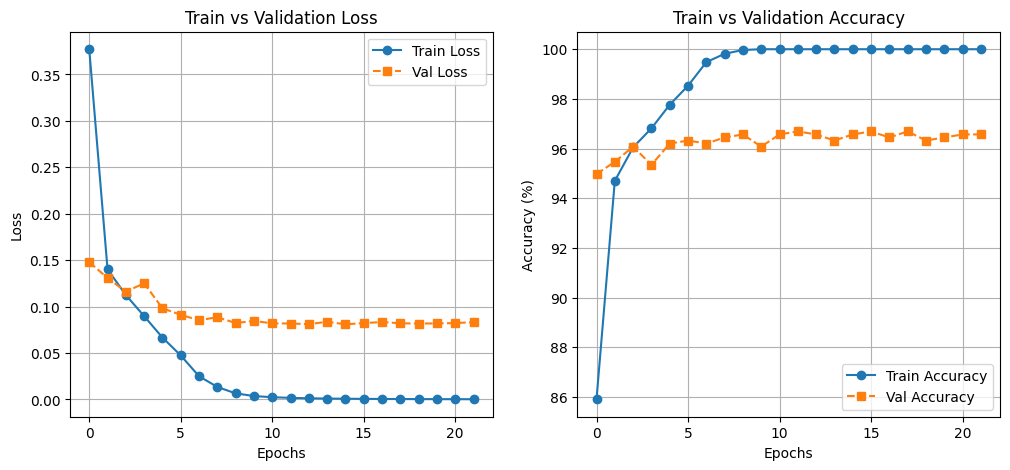

In [11]:
#  7. Training 실행
epochs = 50  # Early Stopping으로 조기 종료 가능
train_loss, val_loss, train_acc, val_acc = train_loop(model, train_loader, val_loader, criterion, optimizer, epochs, device=device, patience=7)

#  8. Loss 및 Accuracy 그래프 출력
def plot_metrics(train_loss, val_loss, train_acc, val_acc):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(train_loss, label='Train Loss', linestyle="-", marker="o")
    axs[0].plot(val_loss, label='Val Loss', linestyle="--", marker="s")
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Train vs Validation Loss')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(train_acc, label='Train Accuracy', linestyle="-", marker="o")
    axs[1].plot(val_acc, label='Val Accuracy', linestyle="--", marker="s")
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy (%)')
    axs[1].set_title('Train vs Validation Accuracy')
    axs[1].legend()
    axs[1].grid(True)

    plt.show()

plot_metrics(train_loss, val_loss, train_acc, val_acc)

In [12]:
#  9. 최적 모델 불러와서 Test 평가
def test_loop(model, X_test, y_test, criterion, device='cpu'):
    best_model_path = "best_model.pth"
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.eval()

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

    with torch.no_grad():
        outputs = model(X_test_tensor)
        loss = criterion(outputs, y_test_tensor)

        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor) * 100

    print(f" 최적 Validation 모델을 사용한 Test Accuracy: {accuracy:.2f}%")
    return loss.item(), accuracy

# Test Accuracy 확인
test_loss, test_acc = test_loop(model, X, y, criterion, device=device)

 최적 Validation 모델을 사용한 Test Accuracy: 99.34%


In [13]:
# 9. 새로운 데이터 예측 함수
def predict(model, X_new, device='cpu'):
    best_model_path = "best_model.pth"

    #  가중치만 로드하도록 변경 (보안 권장)
    model.load_state_dict(torch.load(best_model_path, map_location=device, weights_only=True))
    model.eval()

    X_new_tensor = torch.tensor(X_new, dtype=torch.float32).to(device)

    with torch.no_grad():
        outputs = model(X_new_tensor)
        _, predictions = torch.max(outputs, 1)

    return predictions.cpu().numpy()

#  예측 예제
X_new_sample = X[:100]
predictions = predict(model, X_new_sample)
print("예측 결과:", predictions)

예측 결과: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [14]:
def analyze_predictions(y_true, y_pred):
    # DataFrame으로 정리하여 보기 쉽게 출력
    df_results = pd.DataFrame({
        'Actual': y_true,
        'Predicted': y_pred,
        'Correct': (y_true == y_pred)  # 맞으면 True, 틀리면 False
    })

    # 정확도 계산
    accuracy = np.mean(df_results['Correct']) * 100  # 퍼센트 변환
    correct_count = df_results['Correct'].sum()
    total_count = len(df_results)

    print(f"\n예측 정확도: {accuracy:.2f}% ({correct_count}/{total_count} 개 맞음)")


#  실제값과 예측값 비교 실행
analyze_predictions(y[:100], predictions)



예측 정확도: 100.00% (100/100 개 맞음)


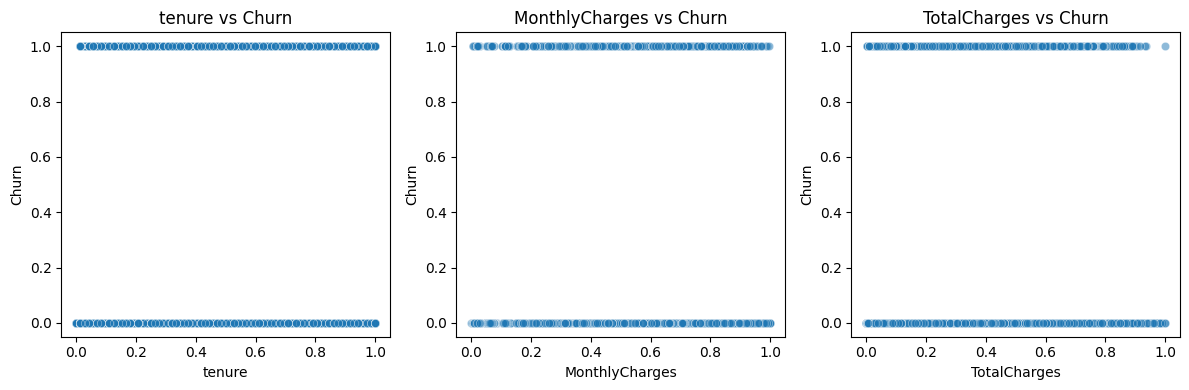

In [ ]:
#비선형데이터 파악


# 주요 연속형 변수 선택
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# 그래프 출력
plt.figure(figsize=(12, 4))

for i, feature in enumerate(numeric_features):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(x=df[feature], y=df['Churn'], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('Churn')
    plt.title(f"{feature} vs Churn")

plt.tight_layout()
plt.show()
